Simulating an Asteroid Which Made a Close Approach to Earth
---------------------------------

- Andres Fraga
- Dr. Fily
- MAT 4930
- 4/28/23

# Preliminary/Objective

In early 2023, NASA observed an asteroid that had an extremely close approach to the Earth. This notebook will be plotting the trajectory of the asteroid in orbit with the Sun and the Earth at different times, find at what point the distance was its shortest, and what that distance was using knowledge of ODE's, previous notebooks regarding celestial bodies in orbit, and a bit of data stealing and manipulation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import norm
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from astroquery.jplhorizons import Horizons

# Asteroid and Earth Data

The asteroid data is taken from a data base and needs to be altered because it is in terms of orbital elements/orbit parameters. The data is obtained through a Python module which sends queries to Nasa's JPL orbital elements database.

We want to get the data in terms of cartesian coordinates. We will be following an algorithm to convert the data into two vectors: an initial condition for position and an initial condition for velocity.

When we get these initial conditions, we will be able to apply our ODE's and Euler integration.

The algorithm wants us to input our data in specific units, however, our data is in a different set of units, so we must convert some of these elements of data to the units the algorithm wants.

[Python Module for the Data](https://astroquery.readthedocs.io/en/latest/api/astroquery.jplhorizons.HorizonsClass.html#astroquery.jplhorizons.HorizonsClass)

In [2]:
#obtaining orbital elements
earth = Horizons(id=399, epochs=2460000.5)
asteroid = Horizons(id='DES=54339759;', epochs=2460000.5)

print('Earth Orbital Elements')
display(earth.elements())

print('Asteroid Orbital Elements')
display(asteroid.elements())



#orbital elements for asteroid (in AU and deg)                                        
a_asteroid = 1.107007392794664 #semi-major axis
e_asteroid = 0.1110841716708629 #eccentricity
peri_asteroid = 355.747064114244 #argument of periapsis
node_asteroid = 125.4852641678352  #longitude of ascending node 
i_asteroid = 3.749019294459166 #inclination 
ma_asteroid = 28.72743889698048 #mean anomaly 



#orbital elements for Earth (in AU and deg)
a_earth = 1.00046308821893 #semi-major axis
e_earth = 0.01670036069367139 #eccentricity
peri_earth = 257.3003200862544 #argument of periapsis
node_earth = 207.7959851726384 #longtitude of ascending node
i_earth = 0.00119959355420473 #inclination
ma_earth = 49.22566821380011 #mean anomaly

Earth Orbital Elements


targetname,datetime_jd,datetime_str,e,q,incl,Omega,w,Tp_jd,n,M,nu,a,Q,P
---,d,---,---,AU,deg,deg,deg,d,deg / d,deg,deg,AU,AU,d
str11,float64,str30,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Earth (399),2460000.5,A.D. 2023-Feb-25 00:00:00.0000,0.01670036069367139,0.9837549937849697,0.00119959355420473,207.7959851726384,257.3003200862544,2459950.52089218,0.98492490884576,49.22566821380011,50.69476365460287,1.00046308821893,1.01717118265289,365.5100980458362


Asteroid Orbital Elements


targetname,datetime_jd,datetime_str,H,G,e,q,incl,Omega,w,Tp_jd,n,M,nu,a,Q,P
---,d,---,mag,---,---,AU,deg,deg,deg,d,deg / d,deg,deg,AU,AU,d
str9,float64,str30,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
(2023 BU),2460000.5,A.D. 2023-Feb-25 00:00:00.0000,29.69,0.15,0.1110841716708629,0.9840363935325469,3.749019294459166,125.4852641678352,355.747064114244,2459966.551654186,0.8462102705694035,28.72743889698048,35.67121084150568,1.107007392794664,1.229978392056781,425.4261765905546


Above is our data for the orbital elements. Now we must follow the algorithm to attain our vectors.

# Algorithm

1. Calcuate or set M(t), which is our mean anomaly. 
     - If t = $t_{0}$: M(t) = $M_{0}$... In our case it is, so we won't worry about the next condition.

2. Solve Kepler's equation: M(t) = E(t) - *e*$\sin$(E) for the eccentric anomaly E(t) with the Newton-Raphson method

3. Obtain the true anomaly *v*(t) from: $v(t) = 2 \arctan2\left[\sqrt{1+e}\sin\left(\frac{E(t)}{2}\right), \sqrt{1-e}\cos\left(\frac{E(t)}{2}\right)\right]$

4. Use the eccentric anomaly E(t) to get the distance to the central body with: $r_{c}$(t) = *a*(1 - *e* *cos* E(t))

5. Obtain the position and velocity vector $\vec{o}(t)$ and $\vec{o'}(t)$ respectively, in the orbital frame (*z*-axis perpendicular to orbital plane, *x*-axis pointing to periapsis of the orbit)

6. Transform the vectors to the intertial frame in bodycentric rectangular coordinates $\vec{r}(t)$ and $\vec{v}(t)$.
 

Each step of the algorithm will have its own cell in order to follow along step by step and will also help in defining a function later in the notebook.

The algorithm source is below:

[Algorithm](https://downloads.rene-schwarz.com/download/M001-Keplerian_Orbit_Elements_to_Cartesian_State_Vectors.pdf)

# Algorithm Function

Below, we have a function to make our conversions from orbital elements to cartesian state vectors. This function will allow us to plug in the orbital elements from the *Horizons* class Python module and convert any orbital elements at a given epoch to their respective cartesian state vectors.

The function takes arguments in units of **AU** and **degrees** where it then converts the values to units that the algorithm mentioned above uses. 

The function returns a position and velocity vector for the body whose orbital elements were fed in.

In [3]:
#this function is relevant only to our dataset given the default epoch value t
def KeplerToCartesian(a, e, per, asc_node, i, M, t0=2460000.5, t=2460000.5, mu=1.32712440041e20):
    
    '''
    a (in AU)= semi-major axis, e = eccentricity, per (in deg) = arg of peri(apsis/helion), 
    asc_node (in deg) = longitude of ascending node, i (in deg) = inclination, 
    M (in deg) = mean anomaly, t (in JD) = considered epoch, mu = standard grav. parameter
    '''
#-------------------------------------Conversion-------------------------------------------------------------
    a = a * 1.496e+11 #unit in m
    per = per * np.pi/180 #in rad
    asc_node = asc_node * np.pi/180 #in rad
    i = i * np.pi/180 #in rad
    M = M * np.pi/180 #in rad

#-------------------------------------Step 1----------------------------------------------------------------
   
    #normalizing mean anomaly for instances where t!=t0
    delta_t = (t-t0)*86400
    ma = M + delta_t*np.sqrt(mu/a**3)
    ma = ma % (2*np.pi)
        
#------------------------------------Step 2-----------------------------------------------------------------    
    
    #using fsolve to solve for eccentric anomaly 
    def fE(E, e=e, M=ma):
        return E - e*np.sin(E) - M
    
    EA = fsolve(fE, ma)[0]
    
#------------------------------------Step 3-----------------------------------------------------------------
    
    vt = 2 * np.arctan2(np.sqrt(1+e)*np.sin(EA/2), np.sqrt(1-e)*np.cos(EA/2))
    
#------------------------------------Step 4-----------------------------------------------------------------    
    
    dcb = a*(1-e*np.cos(EA))
    
#------------------------------------Step 5-----------------------------------------------------------------    
    
    #position vector (orbital frame)
    ot = dcb*np.array([np.cos(vt), np.sin(vt), 0])
    
    #velocity vector (orbital frame)
    ot_prime = (np.sqrt(mu*a)/dcb)*np.array([-np.sin(EA), np.sqrt(1-(e**2))*np.cos(EA), 0])
#------------------------------------Step 6-----------------------------------------------------------------
   
    #defining components for position vector
    x = ot[0] * (np.cos(per)*np.cos(asc_node) - np.sin(per)*np.cos(i)*np.sin(asc_node))\
        - ot[1] * (np.sin(per)*np.cos(asc_node) + np.cos(per)*np.cos(i)*np.sin(asc_node))
    
    y = ot[0] * (np.cos(per)*np.sin(asc_node) + np.sin(per)*np.cos(i)*np.cos(asc_node))\
        + ot[1] * (np.cos(per)*np.cos(i)*np.cos(asc_node) - np.sin(per)*np.sin(asc_node))
    
    z = ot[0] * (np.sin(per)*np.sin(i)) + ot[1] * (np.cos(per)*np.sin(i))
 
    #defining components for velocity vector
    x_prime = ot_prime[0] * (np.cos(per)*np.cos(asc_node) - np.sin(per)*np.cos(i)*np.sin(asc_node))\
            - ot_prime[1] * (np.sin(per)*np.cos(asc_node) + np.cos(per)*np.cos(i)*np.sin(asc_node))
    
    y_prime = ot_prime[0] * (np.cos(per)*np.sin(asc_node) + np.sin(per)*np.cos(i)*np.cos(asc_node))\
            + ot_prime[1] * (np.cos(per)*np.cos(i)*np.cos(asc_node) - np.sin(per)*np.sin(asc_node))

    z_prime = ot_prime[0] * (np.sin(per)*np.sin(i)) + ot_prime[1] * (np.cos(per)*np.sin(i)) 

    #position vector
    pos = np.array([x,y,z])
    
    #velocity vector
    vel = np.array([x_prime, y_prime, z_prime])
    
    #returns cartesian state vector of the object in our system/data set
    return pos, vel

# Using Function
We were able to encapsulate the entirety of the algorithm into a function. Now that we have this function, we will be using it to define the state vectors of objects in our system to apply our integration methods to.

In [4]:
#our position and velocity state vectors for each body 

#asteroid
ast = KeplerToCartesian(a_asteroid, e_asteroid, peri_asteroid, node_asteroid, i_asteroid, ma_asteroid)

#earth
ear = KeplerToCartesian(a_earth,e_earth,peri_earth,node_earth,i_earth,ma_earth)

#slice for relevant vectors: 
#Ex. ast[0] is the position vector for the asteroid and ast[1] is the velocity vector. ast[0][0] is the x component of the 
#position vector for the asteroid, ast[0][1] is the y component of the position vector for the asteroid, etc.

# Implementing the Sun and Masses of Each Object

In our simulation, we will be simulating the Sun at the origin and also include all of the positions of each object into one array as well as all of the velocities of each object into another way in order to compute the orbits of all the bodies in gravitational interaction with one another.

In [5]:
#calculations for the mass of the asteroid

#formula for the volume of a sphere 
vol = (4/3)*np.pi*(4**3) 

#density of the asteroid 
den = 3000
#mass of the asteroid
mass = vol*den

#defining values for the state variables of each body

#asteroid
r1, v1, m1 = ast[0], ast[1], mass 

#earth
r2, v2, m2 = ear[0], ear[1], 5.972e24  

#sun
r3, v3, m3 = np.array([0,0,0]), np.array([0,0,0]), 1.989e30

- [Value for the Diameter and Density of the Asteroid](https://impact.ese.ic.ac.uk/ImpactEarth/cgi-bin/crater.cgi?dist=0.0001&distanceUnits=1&diam=8&diameterUnits=1&pdens=&pdens_select=3000&vel=11.4&velocityUnits=1&theta=45&wdepth=&wdepthUnits=1&tdens=2750)

- [Mass of the Earth](https://nssdc.gsfc.nasa.gov/planetary/factsheet/sunfact.html)

- [Mass of the Sun](https://www.space.com/42649-solar-mass.html)

# Function to Compute Orbits

In a previous notebook, the *compute_orbits* function was used in order to accomplish, essentially the same thing that this notebook is doing.

There is a small catch however, the data obtained at the epoch for the asteroid actually started after the close approach. In other words, the data we obtained does not include some relevant information. However, since we have state vectors at a specific time, which we'll use to approximate future positions, we can use the same logic to approximate positions in the past for the asteroid.

As a result, the *compute_orbits* function will be slightly modified in order to do this computation. 

In [6]:
def compute_orbits(R0, V0, M, tmax=10, dt=1e-2, center_of_mass_frame=True, rtol=1e-6, atol=1e-6, G=6.6743e-11):
    '''
    Compute the trajectories of a list of N objects in gravitational interaction.
    
    Arguments:
      R0:   Initial position of each object (Nx3 array).
      V0:   Initial velocity of each object (Nx3 array).
      M:    Mass of each object (N array).
      tmax: Duration of the integration.
      dt:   Time step of the integration./Resolution of output.
    Output:
      T: Array of times (1D array of size M where M is the number of time steps).
      R: Array of positions (MxNx3 array).
         R[i,j,k] is the k-th position coordinate (0=x, 1=y, 2=z) of object j at time step i.
      V: Array of velocities (MxNx3 array).
         V[i,j,k] is the k-th velocity component (0=x, 1=y, 2=z) of object j at time step i.
    '''
    
    # Make sure the initial conditions are numpy arrays.
    r0 = np.array(R0)
    v0 = np.array(V0)
    m  = np.array(M)
    n  = len(m) # r0, v0, and m should all have the same length
    assert(r0.shape[0]==v0.shape[0]==len(m))
    
    # Switch to the frame of the center of mass.
    if center_of_mass_frame:
        r_  = np.sum(m[:,None]*r0,axis=0)/np.sum(m) # Position of the center of mass.
        v_  = np.sum(m[:,None]*v0,axis=0)/np.sum(m) # Velocity of the center of mass.
        r0 -= r_[None,:]
        v0 -= v_[None,:]

    # Create initial state variable.
    x0 = np.array([r0, v0]).flatten()

    # Specify the differential equation.
    def dxdt(t, x, n=n):
        r,v  = x.reshape((2,n,3))
        drdt = v
        dvdt = np.zeros((n,3))
        for i in range(n):
            for j in range(i):
                rij = r[j]-r[i]
                fij = G*rij/norm(rij)**3
                dvdt[i] += m[j]*fij
                dvdt[j] -= m[i]*fij
        return np.array([drdt,dvdt]).flatten()
        
    sol = solve_ivp(dxdt, [0,tmax], x0, t_eval=np.arange(0,tmax,np.sign(tmax)*dt), atol=atol, rtol=rtol)
    R,V = sol.y.reshape((2,n,3,-1))
    return sol.t, R, V

# Before the Integration

Before we go about implementing the integration techniques to approximate future (and past) positions, let's visualize what the state positions are for the Sun, Earth, and the asteroid.

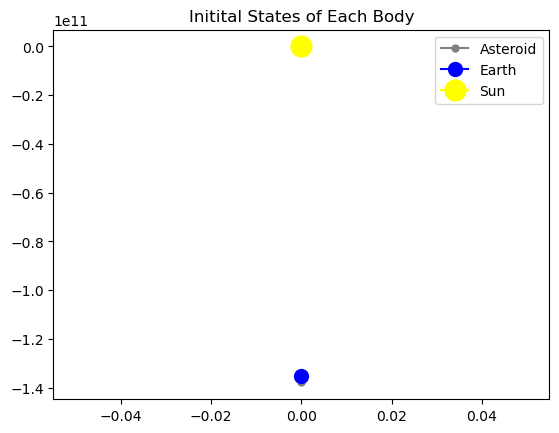

In [7]:
%matplotlib inline

#plotting the asteroid
plt.plot(r1[0:1], marker = 'o', ms = 5, color = 'gray', label = 'Asteroid')

#plotting the earth
plt.plot(r2[0:1], marker = 'o', ms = 10, color = 'blue', label = 'Earth')

#plotting the sun
plt.plot(r3[0:1], marker = 'o', ms = 15, color = 'yellow', label = 'Sun')

plt.title('Initital States of Each Body')
plt.legend()
plt.show()

Above we can see that at our initial states, the Earth and the asteroid are almost directly on top of one another, from here, we will be approxmiating the positons of the asteroid and be able to plot the trajectory of both the Earth and the asteroid around the Sun.

# Calculating the Three Integrated Bodies

*compute_orbits* requires a parameter for how long you want to simulate for, in seconds. We will be defining a variable for **a year** because that's how long it takes the Earth to make one full orbit around the Sun. 

However, if you recall from earlier in the notebook, the asteroid is simulated in the middle of all the relevant data that was obtained, so not only will we have a variable to simulate a year in seconds, but also a variable to simulate a year in **the past** in seconds.

This way, we should obtain all the relevant data for the asteroid.

In [8]:
#converting elements to necessary parameters for 'compute_orbits' function

Ri = [r1, r2, r3]
Vi = [v1, v2, v3]
M = [m1, m2, m3]


#creating a variable to simulate for a year
one_year = 60*60*24*365

#creating the same variable but for the past
one_year_past = -1 * one_year

Tf, Rf, Vf = compute_orbits(Ri, Vi, M, tmax=one_year, dt=1e4)
Tp, Rp, Vp = compute_orbits(Ri, Vi, M, tmax=one_year_past, dt=1e4)

In [9]:
#merging the past and future positions of the asteroid along time axis
Rpf = np.concatenate((Rp[:,:,::-1], Rf[:,:,1:]), axis=2)

Rpf_ast = Rpf[0] # asteroid only
Rpf_ear = Rpf[1] # earth only

#same as the two above but for the times
Tpf = np.concatenate((Tp[::-1], Tf[1:]))

# Plotting in 3D

<IPython.core.display.Javascript object>


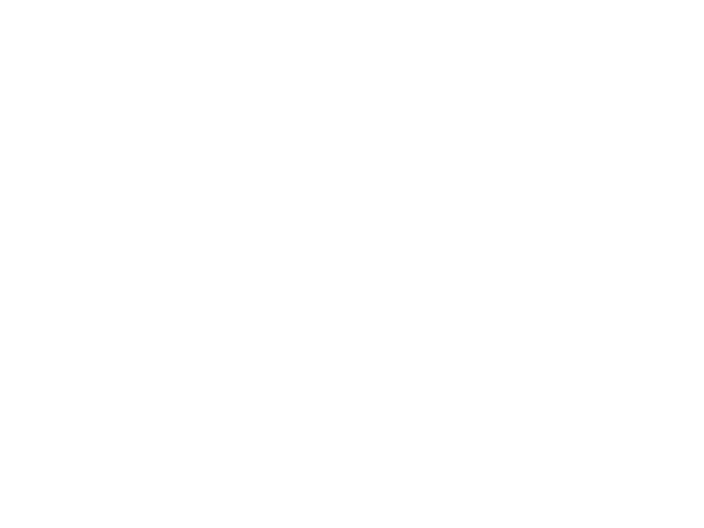

In [10]:
#plotting the bodies in a 3-dimensional plane and making it interactive
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.plot(Rpf_ast[0], Rpf_ast[1], Rpf_ast[2], color = 'gray', label = 'Asteroid')
ax.plot(Rpf_ear[0], Rpf_ear[1], Rpf_ear[2], label = 'Earth')
ax.plot(Rf[2,0], Rf[2,1], Rf[2,2], marker = 'o', ms = 10, color = 'yellow', label = 'Sun')
plt.title('Trajectory of the Earth and Asteroid around the Sun')
plt.legend()
plt.show()

# Plotting in 2D

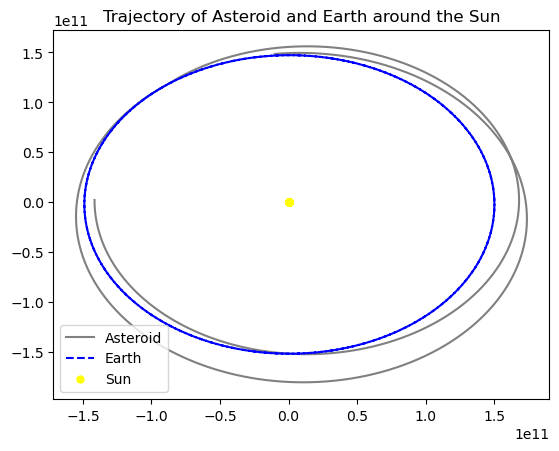

In [11]:
%matplotlib inline

plt.plot(Rpf_ast[0],Rpf_ast[1], color = 'gray', label = 'Asteroid') #asteroid
plt.plot(Rpf_ear[0], Rpf_ear[1], '--', color='blue', label = 'Earth') #earth
plt.plot(Rf[2,0], Rf[2,1], 'o', ms=5, color='yellow', label='Sun')
plt.title('Trajectory of Asteroid and Earth around the Sun')
plt.legend()
plt.show()

# Result of the Plots
Above are two plots, interactive 3D model of the trajectories of both the Earth and the asteroid around the Sun and a 2D version to make it simpler to understand how the trajectories look when looked at from overhead. 

The 2D plot is similar to what the end result of the Wikipedia animation is for the same simulation, just mirrored. The source for the animation is below.

We can see the asteroid's trajectory before and after the epoch (time of data collection). While the 2D plot or 3D plot could give us a hint as to when the asteroid came closest to the Earth, the most definitive way would be a mathematical approach.

We will take the positions of the asteroid and the Earth and find the norm of their difference, which will give us the distance. From there, we just need to use *np.min* in order to see what the smallest distance is, i.e. the closest approach.

[Wikipedia Animation](https://en.wikipedia.org/wiki/2023_BU#/media/File:Animation_of_2023_BU_around_Sun.gif)

# Finding the Closest Approach

In [12]:
#calculating the norm of the difference, which is the distance, 
#so we can maintain an array of positions rather than a singular 
#value
d = norm(Rpf_ast - Rpf_ear, axis=0)

#finding index of the smallest value for d
i_min = np.argmin(d)   

#the smallest value of d
d_min = d[i_min] #this is in meters

#this is in km
minimum_km = d_min/1000 

print(f'The closest approach of the asteroid to the Earth was (in km): {minimum_km}')

#defining a variable that holds the time in seconds for the closest approach
time_min = Tpf[i_min] 

#date and approximated time of observation
dtm_ini = datetime.datetime(2023, 2, 25, 8, 0, 0) 

#date of the closest approach
print(dtm_ini + datetime.timedelta(seconds=time_min))

The closest approach of the asteroid to the Earth was (in km): 30539.145898820665
2023-01-27 06:46:40


Above we can see the shortest distance at which the asteroid was relative to  Earth, which was ~30,539 km away.

We can also see what date and time it occurred as well. 
The asteroid made its close approach on January 27th, 2023 at approximately 6:46 AM

# Conclusion
In this notebook, using ODE's, Euler integration, real data from NASA's JPL database, and conversions, we were able to simulate a real asteroid that made a close approach with the Earth and determine what the distance of that close approach was and when it happened. 

We plotted the trajectory of the asteroid and the Earth around the Sun both in 3D and 2D in order to visualize teh asteroid's trajectory.

We were also able to determine that the asteroid's closest approach was roughly 30,539 kilometers from Earth and that the asteroid did this at approximately 6:46 AM on January 27th, 2023.